In [21]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import shutil
from datetime import datetime
from nrt_wind.wind import read_wind_mag
from nrt_wind.Pre_processing import create_hodogram_realFR_t_minus_24hr
from nrt_wind.DeepFRi_test import cnn_model_fit_10_60
from nrt_wind.Prepare_list import prepare_pre_list
from nrt_wind.Prepare_list import boundary_finding
from nrt_wind.Prepare_list import boundary_w_bth
from nrt_wind.DicFR_test import DicFR

Applying DeepFRi and DicFR models on real solar wind time series and deriving list of FRs with start and end boundaries and geoeffectiveness.

/Users/sanchitapal/Documents/AI_ML/nrt_wind/Pre_processing.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(0.54,0.54))


26
1/1 [==============================] - 0s 130ms/step


2024-03-18 16:21:37.690068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:37.857273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 47ms/step


2024-03-18 16:21:37.953973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:38.034580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:38.117831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 45ms/step


2024-03-18 16:21:38.210158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:38.291171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:38.371390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 44ms/step


2024-03-18 16:21:38.455882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:38.534770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:38.612217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 46ms/step


2024-03-18 16:21:38.695271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:38.776298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:38.851360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 45ms/step


2024-03-18 16:21:38.932768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:39.010658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:39.086872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 46ms/step


2024-03-18 16:21:39.170397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:39.251610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:39.333723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 45ms/step


2024-03-18 16:21:39.431811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:39.510545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:39.587225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 48ms/step
1


2024-03-18 16:21:39.668258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-18 16:21:39.752836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/Users/sanchitapal/Documents/AI_ML/nrt_wind/Prepare_list.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(imgPath+inputfile, sep=" |

'no FRs'

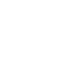

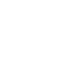

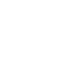

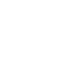

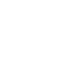

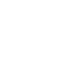

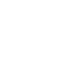

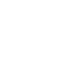

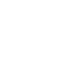

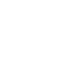

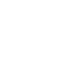

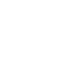

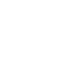

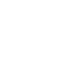

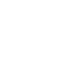

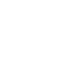

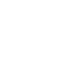

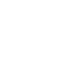

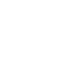

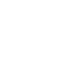

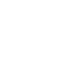

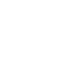

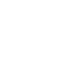

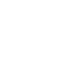

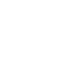

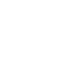

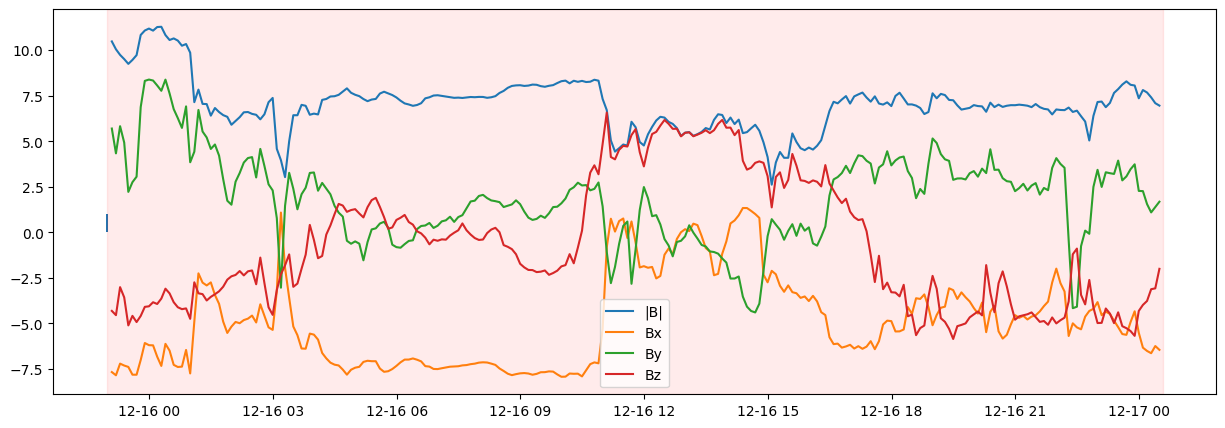

In [22]:
imgPath='./nrt_wind/test/'
path = os.path.join(imgPath, 'bx_by')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)
path = os.path.join(imgPath, 'bx_bz')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)
path = os.path.join(imgPath, 'bz_by')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)

path = os.path.join(imgPath, 'concat')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)
#####........................Start and end time during which users would like to search for FRs..........................
st='2023-12-16 00:00:00'
et='2023-12-16 01:00:00'

#####........................Pre-processing and preparing hodograms............................................
create_hodogram_realFR_t_minus_24hr(st,et,imgPath)
#####........................Applying DeepFRi model............................................
input='*_test.txt'
file=imgPath+input
cnn_model_fit_10_60(imgPath,file)

#####........................Preparing List1 and List2............................................
list1_prime='List1_prime.txt'
prepare_pre_list(imgPath,input,list1_prime)
list1= open(imgPath+'list1.txt', 'w')
if os.path.getsize(imgPath+list1_prime) == 0:
        print('no FRs')
else:  
    df= pd.read_csv(imgPath+list1_prime, sep=" ", header=None)
    for i in df.index:
        tstart=df[0][i]+' '+df[1][i]
        tend=df[2][i]+' '+df[3][i]
        boundary_finding(imgPath,list1_prime,tstart,tend,list1)
    list1.close() 
outfile= 'List2.txt'
list2= open(imgPath+outfile, 'w')
df= pd.read_csv(imgPath+list1, sep=" ", header=None)
for i in df.index:
  tstart=df[0][i]+' '+df[1][i]
  tend=df[2][i]+' '+df[3][i]
  boundary_w_bth(imgPath,list1,tstart,tend,list2)
  list2.close() 

#####........................Applying DicFR model and create the Final list............................................
finallist='Final_list.txt'
DicFR(imgPath,outfile,finallist)




Plotting FRs embeded in solar wind data.

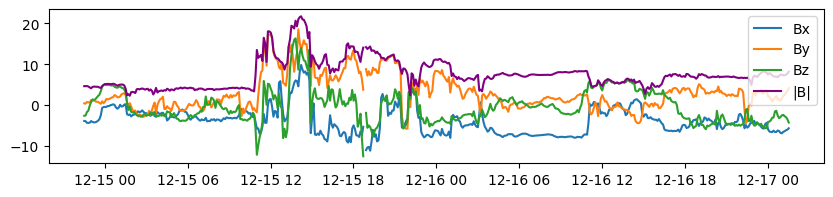

In [19]:
st='2023-12-16 00:00:00'
et='2023-12-16 01:00:00'
npoint=256
window_duration=24 #in hours
l=int(np.round(window_duration*60./npoint)) 

tts=pd.to_datetime((datetime.strptime(str(st), "%Y-%m-%d %H:%M:%S")-datetime(1970, 1, 1, 0, 0)).total_seconds()-l*npoint*60.,unit='s')
tte=pd.to_datetime((datetime.strptime(str(st), "%Y-%m-%d %H:%M:%S")-datetime(1970, 1, 1, 0, 0)).total_seconds()+l*npoint*60.,unit='s')

df= read_wind_mag( tts,tte)
bxn=df.Bx.rolling(window=l,step=l).mean()
byn=df.By.rolling(window=l,step=l).mean()
bzn=df.Bz.rolling(window=l,step=l).mean()  
plt.figure(figsize=(10, 2))
plt.plot(bxn,label='Bx')
plt.plot(byn,label='By')
plt.plot(bzn,label='Bz')
plt.plot(np.sqrt(bxn*bxn+byn*byn+bzn*bzn),label='|B|',color='purple')
plt.legend()
if os.path.getsize(imgPath+'List2.txt') != 0:
     df_list2= pd.read_csv(imgPath+'List2.txt', sep=" ", header=None)
     FR_s_l2=pd.to_datetime(df_list2[0][i]+' '+df_list2[1][i])
     FR_e_l2=pd.to_datetime(df_list2[2][i]+' '+df_list2[3][i])
     plt.axvspan(FR_s_l2,FR_e_l2, ymin=0, ymax=1, alpha=0.05, color='green')
if os.path.getsize(imgPath+'Final_list.txt') != 0:
     df_final= pd.read_csv(imgPath+'Final_list.txt', sep=" ", header=None)
     FR_s=pd.to_datetime(df_final[0][i]+' '+df_final[1][i])
     FR_e=pd.to_datetime(df_final[2][i]+' '+df_final[3][i])
     if df_final[7][i]!=0:
          plt.axvspan(FR_s,FR_e, ymin=0, ymax=1, alpha=0.1, color='green')


In [17]:
df_final

,0,1,2,3,4,5,6,7,8
0,2023-12-16,02:01:33,2023-12-17,04:27:33,NaN,-6.654476,0.587692,0,NaN


In [8]:
list2

<_io.TextIOWrapper name='./nrt_wind/List2.txt' mode='w' encoding='UTF-8'>